Informe Técnico - Examen Transversal: Caso Counter Strike

Importaciones específicas para Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Cargar los datos
from google.colab import files
uploaded = files.upload()

# Leer el archivo CSV
df = pd.read_csv('Anexo_ET_demo_round_traces_2022_corregido.csv', low_memory=False)

# Eliminar columna de índice innecesaria si existe
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

Saving Anexo_ET_demo_round_traces_2022_corregido.csv to Anexo_ET_demo_round_traces_2022_corregido.csv


Preparacion de datos

In [2]:
# Asignar nombres correctos a las columnas
column_names = [
    'PlayerId', 'Map', 'Team', 'InternalTeamId', 'MatchId', 'RoundId', 'RoundWinner',
    'MatchWinner', 'Survived', 'AbnormalMatch', 'TimeAlive', 'TravelledDistance',
    'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown', 'PrimaryAssaultRifle',
    'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol', 'FirstKillTime',
    'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
    'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue', 'MatchKills',
    'MatchFlankKills', 'MatchAssists', 'MatchHeadshots'
]

if df.columns[0] == '600':
    df.columns = column_names

# Seleccionar características relevantes
features = [
    'TeamStartingEquipmentValue',
    'RoundStartingEquipmentValue',
    'TimeAlive',
    'TravelledDistance',
    'RoundAssists',
    'RoundHeadshots'
]

# Convertir columnas a numéricas
df[features + ['MatchKills']] = df[features + ['MatchKills']].apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores nulos
df = df.dropna(subset=features + ['MatchKills'])

# Crear variable objetivo binaria (HighKills = 1 si MatchKills >= 5)
df['HighKills'] = (df['MatchKills'] >= 5).astype(int)

# Balancear las clases
df_majority = df[df['HighKills'] == 0]
df_minority = df[df['HighKills'] == 1]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Dividir datos
X = df_balanced[features]
y = df_balanced['HighKills']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipython-input-2-3534164682.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HighKills'] = (df['MatchKills'] >= 5).astype(int)


Visualizacion y resultados

### Resultados para Random Forest:
Accuracy: 0.8824

Matriz de Confusión:
[[7 2]
 [0 8]]
### Reporte de Clasificación - Random Forest ###
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.80      1.00      0.89         8

    accuracy                           0.88        17
   macro avg       0.90      0.89      0.88        17
weighted avg       0.91      0.88      0.88        17



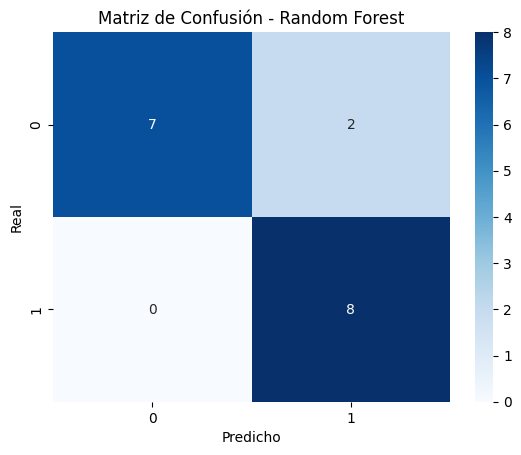

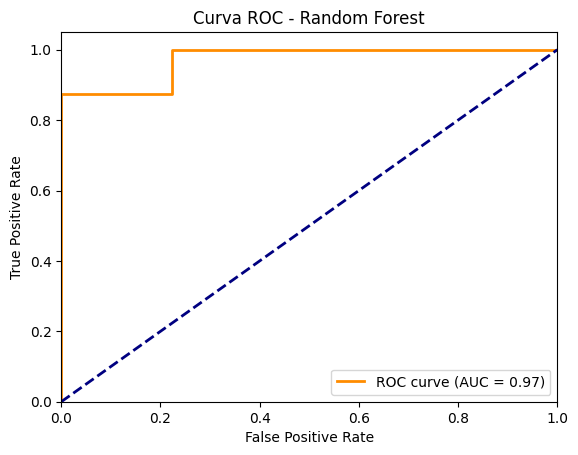

In [3]:
# Definición del modelo
rf_model = RandomForestClassifier(random_state=42)

# Entrenamiento
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Métricas
print("### Resultados para Random Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}\n")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rf))

print("### Reporte de Clasificación - Random Forest ###")
print(classification_report(y_test, y_pred_rf))
print("="*50)

# Gráfico de matriz de confusión
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = roc_auc_score(y_test, y_proba_rf)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.show()